In [1]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install -upgrade opencv-contrib-python

Cloning into 'Facial-Expression-Dataset'...
remote: Enumerating objects: 34052, done.
remote: Total 34052 (delta 0), reused 0 (delta 0), pack-reused 34052
Receiving objects: 100% (34052/34052), 52.31 MiB | 30.42 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (35887/35887), done.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-15a67p4l
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-15a67p4l
     |████████████████████████████████| 47.8 MB 1.8 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112723 sha256=fc54b5f2ca7528f95bf389e8be08c30e851cbff2c235a0120e10b24629ad6e78
  Stored in directory: /tmp/pip-ephem-wheel-cache-msz8qcqg/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Un

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
from torch.utils.data import DataLoader
import timm
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
trainDataPath = '/content/Facial-Expression-Dataset/train/'
validationDataPath = '/content/Facial-Expression-Dataset/validation/'

In [4]:
learningRate = 0.003
batchSize = 256
epochs = 12
device = 'cuda'
modelName = 'efficientnet_b0'

In [5]:
# from torchvision.transforms.transforms import RandomHorizontalFlip
trainAugmentation = T.Compose([
                              #  T.RandomHorizontalFlip(p = 0.5),
                              #  T.RandomHorizontalFlip(degrees = (-20, 20)),
                               T.RandomRotation(10),
                               T.ToTensor()
                               ])

In [6]:
# from torchvision.transforms.transforms import RandomHorizontalFlip
validationAugmentation = T.Compose([T.ToTensor()])

In [7]:
trainData = ImageFolder(trainDataPath, transform = trainAugmentation)
validationData = ImageFolder(validationDataPath, transform = validationAugmentation)

In [8]:
print(len(trainData))
print(len(validationData))

28821
7066


In [9]:
print(trainData.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [10]:
trainLoader = DataLoader(trainData, batch_size = batchSize, shuffle = True)
validationLoader = DataLoader(validationData, batch_size = batchSize)


In [11]:
class FaceModel(nn.Module):
    def __init__(self):
        super(FaceModel, self).__init__()

        self.effNet = timm.create_model(model_name = modelName, pretrained = True, num_classes = 7)
    
    def forward(self, images, labels = None):
        logits = self.effNet(images)
        if(labels != None):
            loss = nn.CrossEntropyLoss()(logits, labels)
            return logits, loss
        
        return logits

In [12]:
model = FaceModel()
model.to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


FaceModel(
  (effNet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True,

In [13]:
def multiclassAccuracy(yPrediction, yTrue) :
    topP, topClass = yPrediction.topk(1, dim = 1)
    equals = topClass == yTrue.view(*topClass. shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [14]:
def trainFunction(model, dataLoader, optimizer, epoch):
    model.train()
    totalLoss= 0
    totalAccuracy = 0
    tk = tqdm(dataLoader, desc = 'EPOCH' + '[TRAIN]' + str(epoch + 1) + '/' + str(epochs))

    for t, data in enumerate(tk):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits, loss = model(images, labels)

        loss.backward()
        optimizer.step()

        totalLoss += loss.item()
        totalAccuracy += multiclassAccuracy(logits, labels)

        tk.set_postfix({'loss' : '%6f' %float(totalLoss / (t+1)), 'Accuracy' : '%6f' %float(totalAccuracy / (t+1))})

    return totalLoss / len(dataLoader), totalAccuracy / len(dataLoader)


In [15]:
def evalFunction(model, dataLoader, epoch):
    model.eval()
    totalLoss= 0
    totalAccuracy = 0
    tk = tqdm(dataLoader, desc = 'EPOCH' + '[VALID]' + str(epoch + 1) + '/' + str(epochs))

    for t, data in enumerate(tk):
        images, labels = data
        images, labels = images.to(device), labels.to(device)


        logits, loss = model(images, labels)



        totalLoss += loss.item()
        totalAccuracy += multiclassAccuracy(logits, labels)

        tk.set_postfix({'loss' : '%6f' %float(totalLoss / (t+1)), 'Accuracy' : '%6f' %float(totalAccuracy / (t+1))})

    return totalLoss / len(dataLoader), totalAccuracy / len(dataLoader)


In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr = learningRate)

In [17]:
bestValidationLoss = np.Inf
tl = []
vl = []
for i in range(epochs):
    trainLoss, trainAccuracy = trainFunction(model, trainLoader, optimizer, i)
    validationLoss, validationAccuracy = evalFunction(model, validationLoader, i)
    tl.append(trainLoss)
    vl.append(validationLoss)

    if validationLoss < bestValidationLoss:
        torch.save(model.state_dict(), 'bestWeights.pt')
        # print('saved')
        bestValidationLoss = validationLoss

EPOCH[VALID]12/12: 100%|██████████| 28/28 [00:05<00:00,  5.09it/s, loss=1.133407, Accuracy=0.616613]


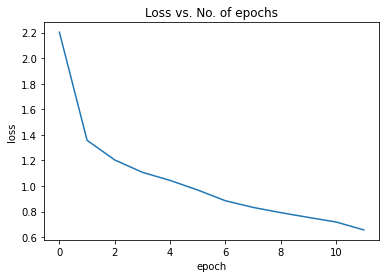

In [18]:
plt.plot(tl)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [19]:
index = 17
model.load_state_dict(torch.load('/content/bestWeights.pt'))

<All keys matched successfully>

Text(0.5, 1.0, '6')

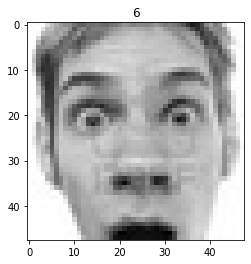

In [20]:
image, label = validationData[7001]
plt.imshow(image.permute(1,2,0))
plt.title(label)

In [21]:
logitsMask = model(image.to(device).unsqueeze(0))
prediction = torch.argmax(logitsMask)
prediction

tensor(6, device='cuda:0')